# Sequence - To - Sequence with Attention

In [ ]:
! pip install torchtext==0.6.0

In [ ]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"

! pip install -U spacy
! python -m spacy download fr_core_news_sm
! python -m spacy download en_core_web_sm

In [232]:
import torch
import torchtext

import numpy as np
import pandas as pd
import spacy

import matplotlib.pyplot as plt
import IPython.display as display
import random

In [233]:
if torch.backends.mps.is_available():
    DEVICE = torch.device(device='mps')
elif torch.cuda.is_available():
    DEVICE = torch.device(device='cuda')
else:
    DEVICE = torch.device(device='cpu')

### Preprocessing

In [235]:
spacy_en = spacy.load('en_core_web_sm')
spacy_fr = spacy.load('fr_core_news_sm')

In [236]:
french = torchtext.data.Field(tokenize= lambda text: [token.text for token in spacy_en.tokenizer(text)],
                              lower = True,
                              init_token = '<sos>',
                              eos_token = '<eos>')

english = torchtext.data.Field(tokenize= lambda text: [token.text for token in spacy_fr.tokenizer(text)],
                              lower = True,
                              init_token = '<sos>',
                              eos_token = '<eos>')

In [237]:
fields = {
    'English': ('eng', english),
    'French': ('fre', french)

}

train_data, test_data = torchtext.data.TabularDataset.splits(
    path='data/',
    train='train_simple.csv',
    test = 'test_simple.csv',
    format='csv',
    fields=fields
)

In [238]:
english.build_vocab(train_data, max_size = 10000, min_freq = 2)
french.build_vocab(train_data, max_size = 10000, min_freq = 2)

In [239]:
batch_size = 64
train_iterator, test_iterator = torchtext.data.BucketIterator.splits(
    (train_data, test_data),
    batch_size = batch_size,
    sort_within_batch = True, # Protizes to have examples are of similar length in a batch, because it reduces padding and save compute.
    sort_key = lambda x: len(getattr(x, 'eng')), # Protizes to have examples are of similar length in a batch, because it reduces padding and save compute.
    device=DEVICE
)

### Learning Loops

In [240]:
pad_idx = french.vocab.stoi['<pad>']
criterion = torch.nn.CrossEntropyLoss(ignore_index=pad_idx)

In [241]:
def one_epoch_train(model: torch.nn.Module, data_loader_train: torch.utils.data.DataLoader,
                    loss_criterion: torch.nn, optim_alog: torch.optim) -> tuple:
    """Function that trains the model for one epoch.

    Args:
        model (torch.nn.Module): Pytorch model we want to train.
        data_loader_train (torch.utils.data.DataLoader): Pytorch dataloader that carries training data.
        loss_criterion (torch.nn): Pytorch loss criteria on which we calculate loss.
        optim_alog (torch.optim): Opimiztion algoritham that we use to update model weights.

    Returns:
        tuple: Tuple carrying Train loss and accuracy
    """
    batch_loss_train = []
    batch_counter = 0
    for batch in data_loader_train:
        input_text = batch.eng.to(DEVICE).permute(1,0)
        target_text = batch.fre.to(DEVICE).permute(1,0)


        # Enabling model training.
        model.train(True)


        #Setting gradients to zero to prevent gradient accumulation.
        optim_alog.zero_grad()

        # Forward pass.
        y_pred_prob = model(input_text, target_text)
        
        y_pred_prob = y_pred_prob[:,1:,:].reshape(-1, y_pred_prob.shape[2])
        target_text = target_text[:, 1:].reshape(-1)

        loss = loss_criterion(y_pred_prob, target_text)

        batch_loss_train.append(loss.item())

        # Back Propagation
        loss.backward()

        # Gradient clipping to prevent exploding gradients
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1)

        # Updating weights
        optim_alog.step()
        
        batch_counter += 1

        del(input_text)
        del(target_text)

    return sum(batch_loss_train)/batch_counter

In [242]:
def inference(model: torch.nn.Module, data_loader_val: torch.utils.data.DataLoader, loss_criterion: torch.nn) -> tuple:
    """Function that calculates test accuracy

    Args:
        model (torch.nn.Module): Pytorch model we want to make inference on.
        data_loader_val (torch.utils.data.DataLoader): Pytorch dataloader that carries validation data.
        loss_criterion (torch.nn): Pytorch loss criteria on which we calculate loss.

    Returns:
        tuple: Tuple carrying Test loss and accuracy
    """

    batch_loss_train = []
    batch_counter = 0

    for batch in data_loader_val:
        input_text = batch.eng.to(DEVICE).permute(1,0)
        target_text = batch.fre.to(DEVICE).permute(1,0)

        # Disabiling model training.
        model.train(False)

        with torch.inference_mode():
            # Forward Pass
            y_pred_prob = model(input_text, target_text)

            y_pred_prob = y_pred_prob[:,1:,:].reshape(-1, y_pred_prob.shape[2])
            target_text = target_text[:, 1:].reshape(-1)

            # Calculating Loss
            loss = loss_criterion(y_pred_prob, target_text)
            batch_loss_train.append(loss.item())

        batch_counter += 1

        del(input_text)
        del(target_text)

    return sum(batch_loss_train)/batch_counter

In [243]:
def training_loop(model: torch.nn.Module, data_loader_train: torch.utils.data.DataLoader, data_loader_val: torch.utils.data.DataLoader,
                  epochs:int, loss_criterion: torch.nn, optim_alog: torch.optim)-> dict:
    """Function that trains the model for the given number of epochs

    Args:
        model (torch.nn.Module): Pytorch model we want to train.
        data_loader_train (torch.utils.data.DataLoader): Pytorch dataloader that carries training data.
        data_loader_val (torch.utils.data.DataLoader): Pytorch dataloader that carries validation data.
        epochs (int): Count of EPOCHS
        loss_criterion (torch.nn): Pytorch loss criteria on which we calculate loss.
        optim_alog (torch.optim): Opimiztion algoritham that we use to update model weights.

    Returns:
        dict: A dictionary that carries the output metrics.
    """

    loss_train = []
    loss_val = []

    # Loop that iterates over each EPOCH
    for epoch in range(epochs):

        #Train the model for one EPOCH
        epoch_loss = one_epoch_train(model, data_loader_train, loss_criterion, optim_alog)
        loss_train.append(epoch_loss)

        # Caluclating Testing results
        val_loss = inference(model, data_loader_val, loss_criterion)
        loss_val.append(val_loss)

        if (epoch+1)%1 == 0:
            print('For Epoch {} We Train Loss:{}, Val Loss:{}'.format(epoch+1, epoch_loss,val_loss))
    return {'training_loss':loss_train, 'val_loss':loss_val}

In [244]:
def plot_metrics(epochs: int,metrics: dict) -> None:
    """Plot the graphs of Training and Testing Accuracy and Loss across Epoches

    Args:
        epochs (int): Number of Epochs
        metrics (dict): A dictionary containing Test and Training datasets' Loss and accuracy
    """

    plt.figure(figsize=(10,10))
    plt.plot(list(range(epochs)), metrics['training_loss'])
    plt.plot(list(range(epochs)), metrics['val_loss'])
    plt.grid()
    plt.legend(['Train', 'Test'])
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Train and Validation loss across epochs')

    plt.show()

In [245]:
def sentence_translator(model: torch.nn.Module, sentence: str, src_corpus: torchtext.data.Field, tgt_corpus: torchtext.data.Field) -> list:
    """Given the model and english sentence it will translate the english sentence to french.

    Args:
        model (torch.nn.Model): Pytorch Model
        sentence (str): English sentence
        src_corpus (torchtext.data.Field): English Corpus (Source Torchtext data field)
        tgt_corpus (torchtext.data.Field): French Corpus (Destination Torchtext data field)

    Returns:
        list: List of words 
    """
    
    # Checking If the sentence is string or not.
    if isinstance(sentence, str):
        tokens = [token.text.lower() for token in spacy_en(sentence)]
    else:
        tokens = [token.lower() for token in sentence]
        
    # Attaching <SOS> token at the beginning of the source sentence
    tokens.insert(0, src_corpus.init_token)
    
    # Attaching <EOS> token at the end of the source sentence
    tokens.append(src_corpus.eos_token)
    
    # Converting the soruce text to sentence vector 
    sentence_vector = [src_corpus.vocab.stoi[token] for token in tokens]
    
    # Creating a tensor from the vector
    sentence_tensor = torch.LongTensor(sentence_vector).unsqueeze(1).to(DEVICE).permute(1,0)
    
    # Performing encoding
    with torch.inference_mode():
        hidden_state, cell_state = model.encoder(sentence_tensor)
        
    # Attaching <SOS> token at the beginning of the destination sentence. 
    outputs = [tgt_corpus.vocab.stoi["<sos>"]]
    
    # Iteration over and producing the sequnce of words of the translated sentence. 
    for _ in range(30):
        
        # Getting previous word to pass it to decoder
        previous_word = torch.LongTensor([outputs[-1]]).to(DEVICE)
        
        # Performing Decoding
        with torch.inference_mode():
            output, hidden_state, cell_state = model.decoder(previous_word, hidden_state, cell_state)
            # Predicting the word
            word_pred = torch.argmax(output, axis=1).item()
            
        # Append the Predicted word 
        outputs.append(word_pred)
        
        # On reaching end of the sentence break the loop
        if torch.argmax(output, axis=1).item() == tgt_corpus.vocab.stoi["<eos>"]:
            break
    
    # Converting translated sentence vector to translated sentence.
    translated_sentence = [tgt_corpus.vocab.itos[idx] for idx in outputs]

    return translated_sentence[1:]

In [246]:
def score_bleu(dataset: torchtext.data.TabularDataset.splits, model: torch.nn.Module, src_corpus: torchtext.data.Field, tgt_corpus: torchtext.data.Field) -> int:
    """ Get BLeU score of the given dataset and its translation.

    Args:
        dataset (torchtext.data.TabularDataset.splits): torch text data set
        model (torch.nn.Model): pytorch model
        src_corpus (torchtext.data.Field): English Corpus (Source Torchtext data field)
        tgt_corpus (torchtext.data.Field): French Corpus (Destination Torchtext data field)

    Returns:
        int: Bleu score of the translation.
    """
    targets = []
    outputs = []

    for translation_record in dataset:
        source_sentence = vars(translation_record)["eng"]
        target_sentence = vars(translation_record)["fre"]

        translated_sentence = sentence_translator(model, source_sentence, src_corpus, tgt_corpus)
        translated_sentence = translated_sentence[:-1]

        targets.append([target_sentence])
        outputs.append(translated_sentence)

    return torchtext.data.metrics.bleu_score(outputs, targets)

## Model Building

#### Encoder

In [247]:
class Encoder(torch.nn.Module):
    def __init__(self, input_size, embedding_size, hidden_size, num_layers, droput_prob):
        super(Encoder, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.dropout = torch.nn.Dropout(droput_prob)
        self.embedding = torch.nn.Embedding(input_size, embedding_size)

        self.lstm = torch.nn.LSTM(embedding_size, hidden_size, num_layers, batch_first=True, dropout=droput_prob)

    def forward(self, x):
        # x shape = (sequence_length, batch_size)
        word_embedding = self.dropout(self.embedding(x))

        _ , (hidden_state, cell_state) = self.lstm(word_embedding)
        return hidden_state, cell_state

#### Decoder

In [248]:
class Decoder(torch.nn.Module):
    def __init__(self, input_size, embedding_size, hidden_size, output_size, num_layers, droput_prob):
        super(Decoder, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.droput = torch.nn.Dropout(droput_prob)
        self.embedding = torch.nn.Embedding(input_size, embedding_size)

        self.lstm = torch.nn.LSTM(embedding_size, hidden_size, num_layers, batch_first=True, dropout=droput_prob)
        self.linear = torch.nn.Linear(hidden_size, output_size)

    def forward(self, x, hidden_state, cell_state):
        # X shape = (batch_size) -> (1,batch_size) because we are predicting one word at a time
        x = x.unsqueeze(1)

        word_embedding = self.droput(self.embedding(x))
        
        # Embedding shape: (1,batch_size,embedding_size)
        output, (hidden_state, cell_state) = self.lstm(word_embedding, (hidden_state, cell_state))
        # Shape of output: (1,batch_size, hidden_size)

        pred = self.linear(output)
        #Shape of pred: (1, batch_size, length_of_vocabulary)
        
        pred = pred.squeeze(1)
     
        return pred, hidden_state, cell_state

#### Seq-2-Seq

In [249]:
class Seq2Seq(torch.nn.Module):
    def __init__(self, input_size_encoder, encoder_embedding_size, input_size_decoder, decoder_embedding_size, hidden_size, 
                 num_layers, output_size, encoder_dropout, decoder_dropout):
        
        super(Seq2Seq, self).__init__()
        self.encoder = Encoder(input_size_encoder, encoder_embedding_size, hidden_size, num_layers, encoder_dropout).to(DEVICE)
        self.decoder = Decoder(input_size_decoder, decoder_embedding_size, hidden_size, output_size, num_layers, decoder_dropout).to(DEVICE)

    def forward(self, src_text, target_text, teacher_force_ratio=0.5):
        batch_size = src_text.shape[0]
        # Src_text = (target_len, batch_size)
        target_len = target_text.shape[1]
        target_vocab_size = len(french.vocab)

        outputs = torch.zeros(batch_size, target_len,target_vocab_size).to(device=DEVICE)

        hidden_state, cell_state = self.encoder(src_text)
        
        # Probability Mass Function defined for the word_selection we should choose
        next_word_selection_actions = ['Guess', 'Truth']
        next_word_selection_probability_distribution = [teacher_force_ratio, 1-teacher_force_ratio]
        

        # Grab Start Token
        x = target_text[:,0]

        for t in range(1, target_len):
            output, hidden_state, cell_state = self.decoder(x, hidden_state, cell_state)
            outputs[:, t, :] = output
            # outputs size = (batch_size, target_vocab_size)
            best_guess = output.argmax(1)
            
            # Sampling type word to select based on the above defined Probability Mass Function.
            word_to_choose = np.random.choice(a = next_word_selection_actions, size=1, 
                                              p=next_word_selection_probability_distribution)
            
            if word_to_choose == 'Guess':
                x = best_guess
            else:
                x = target_text[:,t]


        return outputs

In [250]:
seq_2_seq_model = Seq2Seq(input_size_encoder=len(english.vocab), encoder_embedding_size = 300, 
                          input_size_decoder = len(french.vocab), decoder_embedding_size = 300, hidden_size = 1024, 
                          num_layers = 2, output_size = len(french.vocab), encoder_dropout = 0.5, decoder_dropout = 0.5).to(DEVICE)

In [251]:
EPOCHS = 20
optimizer = torch.optim.Adam(seq_2_seq_model.parameters(), lr=1e-3)

In [252]:
output_metrics = training_loop(model = seq_2_seq_model, data_loader_train = train_iterator, data_loader_val = test_iterator,
                               epochs = EPOCHS, loss_criterion = criterion, optim_alog = optimizer)

For Epoch 1 We Train Loss:4.067622143751497, Val Loss:3.3766140937805176
For Epoch 2 We Train Loss:3.336339997637803, Val Loss:3.1368614860943387
For Epoch 3 We Train Loss:3.0239617399349332, Val Loss:2.876043894461223
For Epoch 4 We Train Loss:2.736353296383171, Val Loss:2.6662503693784987
For Epoch 5 We Train Loss:2.4918616850664663, Val Loss:2.5359183251857758
For Epoch 6 We Train Loss:2.2388971390997527, Val Loss:2.346340239048004
For Epoch 7 We Train Loss:2.027232867137642, Val Loss:2.25959381035396
For Epoch 8 We Train Loss:1.8245784105009335, Val Loss:2.118372998067311
For Epoch 9 We Train Loss:1.6330646697882634, Val Loss:2.0893683348383223
For Epoch 10 We Train Loss:1.4774082777606454, Val Loss:1.9964070660727364
For Epoch 11 We Train Loss:1.3378584244448668, Val Loss:1.9797365324837821
For Epoch 12 We Train Loss:1.2169280955745916, Val Loss:1.9007436505385809
For Epoch 13 We Train Loss:1.108711129920498, Val Loss:1.899082520178386
For Epoch 14 We Train Loss:1.0167276574547883

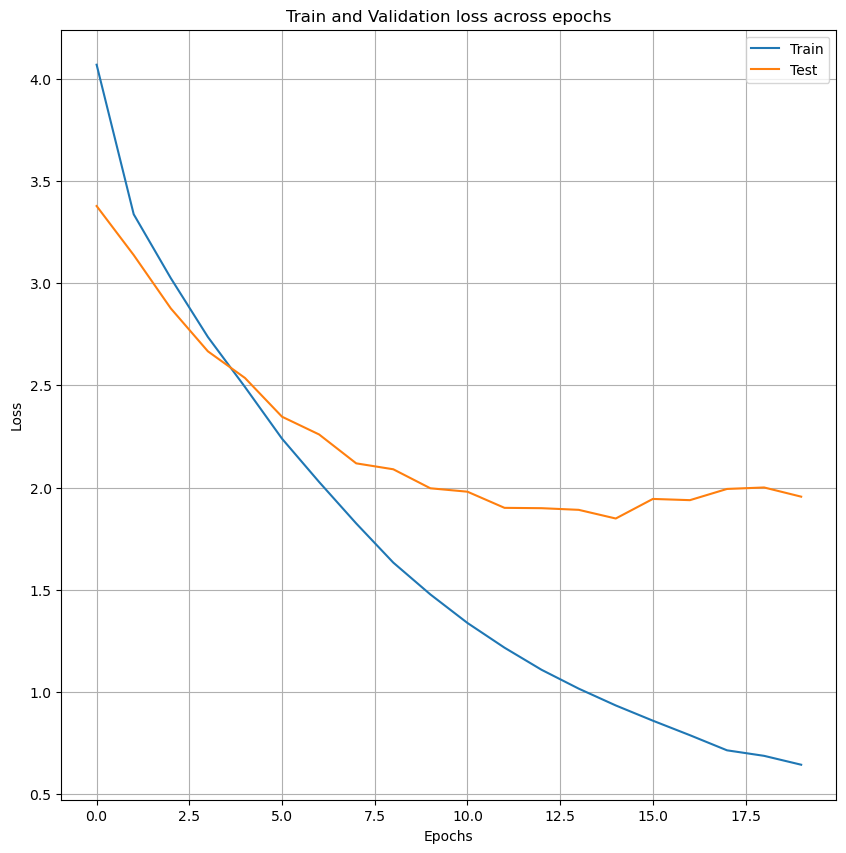

In [253]:
plot_metrics(EPOCHS, output_metrics)

In [ ]:
print('Train BLEU Score:{0}'.format(score_bleu(train_data, seq_2_seq_model, english, french)))

In [254]:
print('Test BLEU Score:{0}'.format(score_bleu(test_data, seq_2_seq_model, english, french)))

Test BLEU Score:0.3225812458863999
